## 银行卡账号识别

本项目使用opencv图像处理的方式来实现对银行卡账号的一个识别。采用模板匹配的方式来识别银行卡的账号。下图是使用的模板
![title](ocr_a_reference.png)

与我们的银行卡账号的数字字体是一致的。
![title](images/credit_card_03.png)

### 思路

我们的思路是利用模板提供的0到9这10个数字，去和银行卡账号的数字做比对，卡号的每个数字都有和模板的这10个数字匹配，取匹配效果最好的。所以我们要提取模板的10个数字，并且也要从银行卡中识别出账号的区域，过滤掉非账号的区域。并且提取账号的每一个数字，然后对这些数字进行模板匹配即可。

In [1]:
# 导入工具包
from imutils import contours
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#matplotlib显示图像
def showImage(image,gray=None):
    if gray is None:
        imageplt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(imageplt)
    else:
        plt.imshow(image,'gray')

In [3]:
#按照等比例调整图片大小，如果不是等比例resize图片，会导致图片拉伸时候变形
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    sizeShape = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        rate = height / float(h)
        sizeShape = (int(w * rate), height)
    else:
        rate = width / float(w)
        sizeShape = (width, int(h * rate))
    resizedImg = cv2.resize(image, sizeShape, interpolation=inter)
    return resizedImg

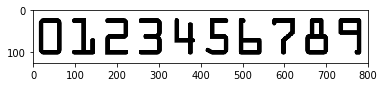

In [4]:
# 读取一个模板图像
templateImg = cv2.imread('./images/template.png')
showImage(templateImg)

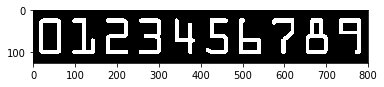

In [5]:
#将模板转成灰度图
templateGray = cv2.cvtColor(templateImg, cv2.COLOR_BGR2GRAY)
# 二值图像
templateGray = cv2.threshold(templateGray, 10, 255, cv2.THRESH_BINARY_INV)[1]
showImage(templateGray,'gray')

接下来我们需要得到模板图片中的每一个数字，也就是要识别出模板图片中每个数字的区域，那么如何能够实现呢。答案很简单，就是利用轮廓，我们对模板图片进行轮廓查找，opencv的findContours函数可以帮我们实现，根据项目的具体需求，我们不需要全部的轮廓，只需要外部轮廓即可。

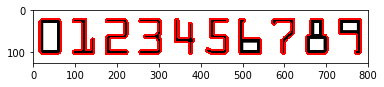

In [6]:
#查找模板的外轮廓，之前做的灰度和二值处理也是为了能够更准确的查找轮廓
ref_, templateCnts, hierarchy = cv2.findContours(templateGray.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(templateImg,templateCnts,-1,(0,0,255),3)
showImage(templateImg)

In [7]:
print ('模板外部轮廓数量:',np.array(templateCnts).shape[0])

模板外部轮廓数量: 10


可以看到我们得到了模板图片的10个数字的所有外轮廓，打印结果也是10个，正好每个数字对应一个轮廓。说明我们的检测方法师正确的。下面我们要对得到的这10个外部轮廓做个排序，因为我们通过findContours查找得到的轮廓集合，并不是按照模板图片给出的从左到右，由0到10的顺序。所以我要重新调整，按照数字从大到小的顺序，对轮廓进行排序，让0对应0的轮廓，1对应1的轮廓，以此类推。这样后面对银行卡账号做比对时候，我们才知道匹配的账号的数字是多少。下面给出轮廓按照数字从大到小排序的方法。

In [8]:
def sort_contours(Contours):
    #取轮廓的最小外接矩形，得到的每个矩形数据格式是(x,y,w,h)，这些元组组成一个list
    boundingRects = [cv2.boundingRect(contour) for contour in Contours] 
    #boundingRects数据格式:[(x,y,w,h),(),....()]
    (Contours, boundingRects) = zip(*sorted(zip(Contours, boundingRects),
                                        key=lambda x: x[1][0], reverse=False))
    #这里的排序的意思是，根据每个数组的外接矩形的x坐标由小到大的顺序来进行排序，因为模板图片的顺序是由小到大，
    #所以越小的数字越靠近左边
    return Contours, boundingRects

In [25]:
templateCnts = sort_contours(templateCnts)[0] #排序，从左到右，按照数字大小升序排列

#创建列表存储排好序的模板数字对应原图像的区域
digitList = []

# 遍历每一个轮廓
for contour in templateCnts:
    # 计算外接矩形并且resize成合适大小
    (x, y, w, h) = cv2.boundingRect(contour)
    #根据轮廓最小外接矩形的坐标和大小，从原模板图中检测出每个数字对应的区域
    region = templateGray[y:y + h, x:x + w]
    #这个resize的大小就是比轮廓的外接矩形稍微大点就可以，因为轮廓的外接矩形宽基本是53,54，
    #而高基本是在85左右，所以我们取个差不多的就可以
    region = cv2.resize(region, (57, 88))

    #每一个数字对应每一个模板数字区域，用来对账号做匹配
    digitList.append(region)

到目前为止我们已经将模板需要的操作全部处理完毕，接下来我们将要处理银行卡的操作，这部分操作相对于模板的操作还要复杂不少，但也是基于opencv图像处理的方法。我们还是按照之前的步骤分布进行说明，我们先将银行卡图片加载进去，进行灰度转换。

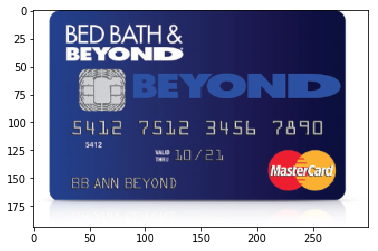

In [10]:
cardImage = cv2.imread('./images/credit_card_03.png')
#调用这个resize函数是为了让宽和高都按照等比例调整大小，如果不按照比例resize大小，会导致图片形变
cardImage = resize(cardImage, width=300)
#原图显示
showImage(cardImage)

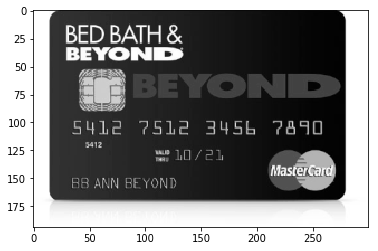

In [11]:
cardGray = cv2.cvtColor(cardImage, cv2.COLOR_BGR2GRAY)
#灰度图显示
showImage(cardGray,'gray')

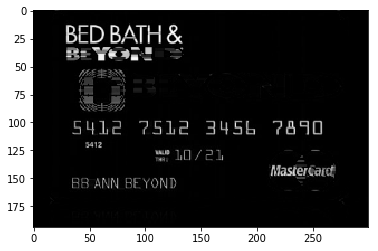

In [12]:
# 初始化卷积核
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)) #(width,height)
#MORPH_TOPHAT操作，突出更明亮的区域，将较为暗淡的区域过滤掉，为了能够更好的识别账号区域
tophatImg = cv2.morphologyEx(cardGray, cv2.MORPH_TOPHAT, rectKernel) 
showImage(tophatImg,'gray') 

可以看到通过MORPH_TOPHAT操作，增强了账号部分，有些较为暗淡的区域没有了。为了能够更好的识别卡号区域，下一步我们试着找到银行卡的边缘部分，通过对图片执行Sobel操作，查找其频率变化部分来确定边缘。

(194, 300)


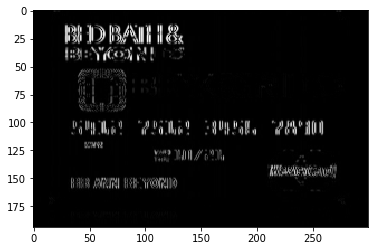

In [13]:
#Sobel对X方向做处理，经过测试发现对X方向执行处理效果最好
gradXImg = cv2.Sobel(tophatImg, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
#执行归一化操作
gradXImg = np.absolute(gradXImg)
(minVal, maxVal) = (np.min(gradXImg), np.max(gradXImg))
gradXImg = (255 * ((gradXImg - minVal) / (maxVal - minVal)))

gradXImg = gradXImg.astype("uint8")
print (np.array(gradXImg).shape)
showImage(gradXImg,'gray')

可以看到账号部分的边缘部分检测到了。账号部分是16个数字，每四个一组。我们直接从图片中取得每个数字区域不太容易。所以我们是打算先获取四个数字组成的每一组
![title](images/1.png)  ![title](images/2.png)
就是上图显示的这四个数字组成的一组。拿到这个组合，我么再做轮廓检测拿到每个组中的每个数字，再和模板的10个数组做对比。为了能够容易得取得四数字组合区域，我们还需要做些图像处理。

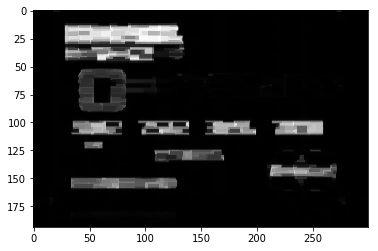

In [14]:
#通过MORPH_CLOSE操作,将4个数字组成的区域连在一起，形成一个整体，这样轮廓检测就能准确得识别这一部分。经过测试发现，直接用膨胀的话，
#会导致4个数字组合区域会和其它框连接到一起，这样就不能准确得识别四数字组了。
gradXImg = cv2.morphologyEx(gradXImg, cv2.MORPH_CLOSE, rectKernel) 
showImage(gradXImg,'gray')

可以看到账号部分的4个数字组合连接在一起了，形成整体，这样轮廓检测就将它们这4个数字的组合作为整个计算出轮廓

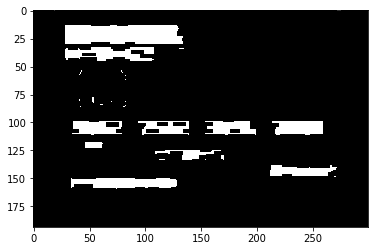

In [15]:
#THRESH_OTSU会自动寻找合适的阈值，适合双峰，需把阈值参数设置为0，二值化能够更好地检测轮廓
threshImg = cv2.threshold(gradXImg, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
showImage(threshImg,'gray')

注意账号部分被分成4个白块，但是这些白块有些地方没有填充好，有黑色的洞，我们可以通过MORPH_CLOSE操作将洞填充一下。

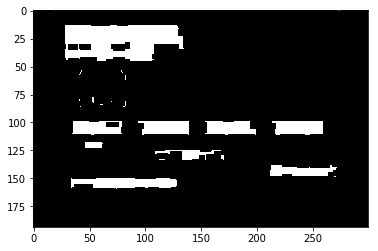

In [16]:
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
threshImg = cv2.morphologyEx(threshImg, cv2.MORPH_CLOSE, sqKernel) #再来一个闭操作
showImage(threshImg,'gray')

可以看到外侧轮廓的洞都给补全了，这样就很容易进行轮廓检测了。

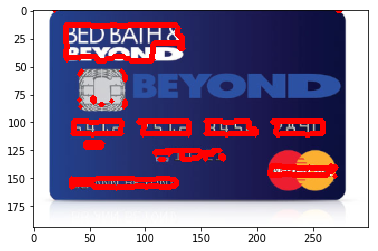

In [17]:
__,cardCnts,__ = cv2.findContours(threshImg.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cardCopyImg = cardImage.copy()
cv2.drawContours(cardCopyImg,cardCnts,-1,(0,0,255),3) 
showImage(cardCopyImg)

In [18]:
rectsList = []

# 遍历轮廓,查看所有轮廓的外接矩形
for (i, c) in enumerate(cardCnts):
    (x, y, w, h) = cv2.boundingRect(c)
    rectsList.append((x, y, w, h))
    
print(len(rectsList))
print(rectsList)

23
[(34, 150, 95, 10), (270, 148, 1, 1), (212, 139, 60, 9), (113, 133, 5, 1), (168, 130, 3, 4), (109, 125, 59, 9), (47, 118, 16, 5), (214, 99, 46, 13), (154, 99, 46, 13), (94, 99, 46, 13), (35, 99, 45, 13), (42, 86, 1, 1), (60, 84, 3, 1), (81, 81, 2, 6), (70, 81, 1, 1), (41, 80, 1, 1), (53, 78, 2, 5), (82, 58, 1, 5), (79, 54, 2, 2), (41, 54, 3, 4), (29, 13, 106, 33), (272, 0, 4, 1), (19, 0, 1, 1)]


In [19]:
rectsList.clear()
print(len(rectsList))

0


可以看到账号部分，4个数字一组的区域都被选中了。下面我们的问题就是确定这些四数字区域。我们通过求取外接矩形，得到它们的区域。我们打印出这些外接矩形，发现(214, 99, 46, 13), (154, 99, 46, 13), (94, 99, 46, 13), (35, 99, 45, 13)这四组就是我们需要的账号区域。我们根据它们的宽高比和宽高大小范围就可以从所有外接矩形中筛选出这四个。

In [21]:
# 遍历所有外轮廓
for (index, contour) in enumerate(cardCnts):
    # 得到最小外接矩形
    (x, y, w, h) = cv2.boundingRect(contour)
    ratio = w / float(h) #宽高比，用来筛选需要的区域

    # 通过这些筛选条件，把符合需要的4个数字组成一组的区域找出来
    if ratio > 2.5 and ratio < 4.0:
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            rectsList.append((x, y, w, h))

在得到这些四个数字一组的四个区域后，我们再分别对这四个区域去计算它们的外接轮廓，这样就得到16个数字的外接轮廓，在取其最小外接矩形。通过外接矩形再原图像上找到每个账号数字对应的区域位置，再重新调整大小，使其和模板图片大小一致，然后使用模板匹配就可以识别出账号。

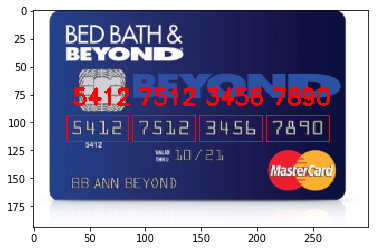

In [26]:
#按照X坐标大小从左到右排序
rectsList = sorted(rectsList, key=lambda x:x[0])
# 遍历账号中4个数字组成的4个组的最小外接矩形
for (index, (rectX, rectY, rectW, rectH)) in enumerate(rectsList):
    accountNumber = []

    # 根据坐标提取每一个组,比实际轮廓稍微大点，这样方便计算，不要紧卡紧
    group = cardGray[rectY - 5:rectY + rectH + 5, rectX - 5:rectX + rectW + 5]

    group = cv2.threshold(group, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # 计算每一组的轮廓
    group_,digitCnts,hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = sort_contours(digitCnts)[0]

    #遍历每个组的每一个数字
    for c in digitCnts:
        #找到当前数值的轮廓的最小外接矩形，resize成合适的的大小
        (x, y, w, h) = cv2.boundingRect(c)
        roi_number = group[y:y + h, x:x + w]
        roi_number = cv2.resize(roi_number, (57, 88))

        #模板和账号数字的匹配得分
        scores = []
        #遍历模板数字区域列表，得到每个模板在原图像上对应的数字区域
        for digitROI in digitList:
            #模板匹配
            result = cv2.matchTemplate(roi_number, digitROI,
                cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)

        #得到最合适的数字，相关系数越大越匹配
        accountNumber.append(str(np.argmax(scores)))

    #绘制出来，将账号每四个数字组成一组的区域用矩形框标识出来
    cv2.rectangle(cardImage, (rectX - 5, rectY - 5),
        (rectX + rectW + 5, rectY + rectH + 5), (0, 0, 255), 1)
    #16个账号数字写在银行卡图片的上边                                      
    cv2.putText(cardImage, "".join(accountNumber), (rectX, rectY - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

showImage(cardImage)